In [3]:
from typing import Iterator

import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import torch
from torch import nn
from torch.utils.data import DataLoader

import torch
from torch import nn
from torch.nn import functional as F, Parameter
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import pytorch_lightning as pl

In [4]:
import utils
from experiments import *

In [ ]:
import wandb
wandb.init(project="Autoencoders Trajectory (dp)")

In [16]:
def aboba(x):
    if x < 0:
        x = 1
    return x

In [18]:
aboba(torch.Tensor([-4]))

1

In [10]:
torch.acos(torch.Tensor([3]))

tensor([nan])

In [47]:
torch.Tensor([1]).item()

1.0

In [48]:
torch.Tensor([1]) * torch.Tensor([[1, 2], [3, 4]])

tensor([[1., 2.],
        [3., 4.]])

In [5]:
class Algebraic(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        # self.funcs = [torch.sin, torch.cos, torch.tan]
        self.s1 = torch.tensor([1], dtype=torch.float32, requires_grad=True)
        self.s2 = torch.tensor(np.zeros(input_dim), dtype=torch.float32, requires_grad=True)
        self.c1 = torch.tensor([1], dtype=torch.float32, requires_grad=True)
        self.c2 = torch.tensor(np.zeros(input_dim), dtype=torch.float32, requires_grad=True)
        self.t1 = torch.tensor([1], dtype=torch.float32, requires_grad=True)
        self.t2 = torch.tensor(np.zeros(input_dim), dtype=torch.float32, requires_grad=True)

    def forward(self, x):
        return torch.concat((x, torch.sin(self.s1 * x + self.s2), torch.cos(self.c1 * x + self.c2), torch.tan(self.t1 * x + self.t2)), dim=1)

    def parameters(self, recurse: bool = True) -> Iterator[Parameter]:
        return iter([self.s1, self.s2, self.c1, self.c2, self.t1, self.t2])

In [6]:
X = np.array([rand_point(2) for _ in range(1000)])
angle = np.arctan2(X[:, 0], X[:, 1])

In [29]:
class MyDecoder(nn.Module):
    def __init__(self):
        super().__init__()
        intermediate_dim = 10
        self.decoder = nn.Sequential(
            Algebraic(1),
            nn.Linear(4, intermediate_dim),
            # nn.Tanh(),
            nn.Linear(intermediate_dim, intermediate_dim),
            # Algebraic(intermediate_dim),
            nn.Tanh(),
            nn.Linear(intermediate_dim, intermediate_dim),
            # Algebraic(intermediate_dim),
            nn.Tanh(),
            nn.Linear(intermediate_dim, intermediate_dim),
            # Algebraic(intermediate_dim),
            nn.Tanh(),
            nn.Linear(intermediate_dim, intermediate_dim),
            # Algebraic(intermediate_dim),
            nn.Tanh(),
            nn.Linear(intermediate_dim, intermediate_dim),
            # Algebraic(intermediate_dim),
            # nn.Tanh(),
            nn.Linear(intermediate_dim, 2),
        )
    def forward(self, x):
        return self.decoder(x)

In [8]:
np.append(angle[:, None], X, axis=1)

array([[-0.6541111 , -0.60845406,  0.7935891 ],
       [ 0.07454658,  0.07447756,  0.99722269],
       [-2.15316432, -0.83516259, -0.55000313],
       ...,
       [-3.0508347 , -0.0906334 , -0.99588432],
       [-0.76002466, -0.68893932,  0.72481902],
       [-1.76012948, -0.98212996, -0.18820401]])

In [9]:
epochs = 1000
batch_size = 20
X_train = np.append(angle[:, None], X, axis=1)
dataloader = DataLoader(X_train, batch_size=batch_size, shuffle=True)
model = MyDecoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

In [79]:
list(Algebraic(32).parameters())

[tensor([1.], dtype=torch.float64, requires_grad=True),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.], dtype=torch.float64,
        requires_grad=True),
 tensor([1.], dtype=torch.float64, requires_grad=True),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.], dtype=torch.float64,
        requires_grad=True),
 tensor([1.], dtype=torch.float64, requires_grad=True),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.], dtype=torch.float64,
        requires_grad=True)]

In [83]:
np.array([[1, 2, 3, 4]]).view(-1)

TypeError: Cannot interpret '-1' as a data type

In [112]:
x = torch.tensor(np.zeros(shape=(13, 1)), dtype=torch.float32)

In [114]:
r1 = nn.Linear(1, 20).forward(x)

In [119]:
Algebraic(20).forward(r1).shape

torch.Size([13, 80])

In [30]:
for epoch in tqdm(range(epochs)):
    running_loss = 0
    for batch_pts in dataloader:
        inp = batch_pts.float()
        a = inp[:, 0, None]
        x_hat = inp[:, 1:]
        # print(a)
        # print(a.shape)
        output = model(a)
        loss = criterion(output, x_hat)
        running_loss += loss.item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    epoch_rms = np.sqrt(running_loss / batch_size)
    print(epoch_rms)

  0%|          | 0/1000 [00:00<?, ?it/s]

0.01870277853049884
0.018359481456797014
0.01853892346270588
0.018977205000491153
0.022003492218787966
0.018959237021930534
0.01866968835221718
0.016825612077838753
0.0169231114899844
0.01824863508580524
0.016376743996752263
0.018558482770919434
0.01472668558208897
0.015098797405893294
0.024310201747465687
0.03803018968788
0.026586131094154534
0.024630363983737146
0.026264621392418707
0.022011962179153337
0.07071913931974785
0.06329374409564978
0.04845033930490648
0.09566625035154268
0.03620528396571796
0.028361780592671137
0.0460844539597619
0.028298467068320985
0.058653846251533
0.045135074932515167
0.03181145707637309
0.06632365088894465
0.06015783658868197
0.05081155662736262
0.04483934593077519
0.04055497767937246
0.03638328844206014
0.05744821683669426
0.07049323782154755
0.03669706139250916
0.06811430229297868
0.07166552828192242
0.05795338192542856
0.047102529835675866
0.03711672372113988
0.03479509122454924
0.0438172162749117
0.07531655199935085
0.0283562402136515
0.0254856031

In [19]:
x_0 = torch.tensor(angle)
x_1 = torch.tensor([np.sin(angle), np.cos(angle)]).transpose(0, 1)

C:\Users\waleko\AppData\Local\Temp\ipykernel_10944\3345830222.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\b\abs_bao0hdcrdh\croot\pytorch_1675190257512\work\torch\csrc\utils\tensor_new.cpp:204.)
  x_1 = torch.tensor([np.sin(angle), np.cos(angle)]).transpose(0, 1)


In [28]:
Algebraic(1).forward(torch.tensor(angle).view(1000, -1).float()).detach().numpy()

array([[-0.6541111 , -0.60845405,  0.7935891 , -0.7667117 ],
       [ 0.07454658,  0.07447756,  0.99722266,  0.07468498],
       [-2.1531644 , -0.8351626 , -0.5500032 ,  1.5184685 ],
       ...,
       [-3.0508347 , -0.09063345, -0.9958843 ,  0.09100801],
       [-0.76002467, -0.68893933,  0.724819  , -0.9504984 ],
       [-1.7601295 , -0.98213   , -0.18820398,  5.2184334 ]],
      dtype=float32)

In [20]:
X

array([[-0.60845406,  0.7935891 ],
       [ 0.07447756,  0.99722269],
       [-0.83516259, -0.55000313],
       ...,
       [-0.0906334 , -0.99588432],
       [-0.68893932,  0.72481902],
       [-0.98212996, -0.18820401]])

In [22]:
x_1.detach().numpy()

array([[-0.60845406,  0.7935891 ],
       [ 0.07447756,  0.99722269],
       [-0.83516259, -0.55000313],
       ...,
       [-0.0906334 , -0.99588432],
       [-0.68893932,  0.72481902],
       [-0.98212996, -0.18820401]])

In [12]:
pred = model(torch.tensor(angle).view(1000, -1).float()).detach().numpy()

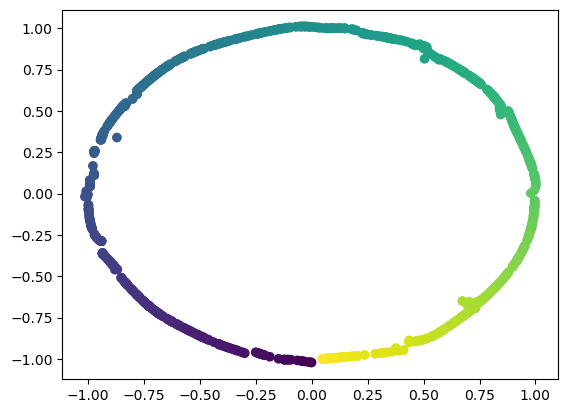

In [15]:
plt.scatter(pred[:, 0], pred[:, 1], c=angle)